In [1]:
import torch
from models import SparseAutoencoder  # Ensure this matches the model definition you uploaded
from huggingface_hub import hf_hub_download
import einops

# Set parameters
repo_name = "charlieoneill/sparse-coding"  # Adjust this with your repo name
model_filename = "sparse_autoencoder.pth"  # Name of the model file you uploaded
input_dim = 768  # Example input dim, adjust based on your model
hidden_dim = 22 * input_dim  # Projection up parameter * input_dim

# Download the model from Hugging Face Hub
model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)

# Load the model
sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim)
sae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
sae.eval()  # Set the model to evaluation model

SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=16896, bias=True)
    (1): ReLU()
  )
  (decoder): Linear(in_features=16896, out_features=768, bias=True)
)

In [2]:
from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader  
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = 'cpu'
layer = 9
l1_weight = 1e-4

# Load the transformer model and activation store
hook_point = "blocks.8.hook_resid_pre"  # Placeholder hook point
saes, _ = get_gpt2_res_jb_saes(hook_point)
sparse_autoencoder = saes[hook_point]
sparse_autoencoder.to(device)
sparse_autoencoder.cfg.device = device
sparse_autoencoder.cfg.hook_point = f"blocks.{layer}.attn.hook_z"
sparse_autoencoder.cfg.store_batch_size = 64

loader = LMSparseAutoencoderSessionloader(sparse_autoencoder.cfg)
transformer_model, _, activation_store = loader.load_sae_training_group_session()

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
from main import loss_fn

batch_tokens = activation_store.get_batch_tokens().to(device)
        
# Obtain activations from the transformer model
with torch.no_grad():
    _, cache = transformer_model.run_with_cache(batch_tokens)
    X = cache["resid_pre", layer]  # Shape: (batch, pos, d_model)
    X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
    del cache
    S_, X_ = sae(X)
    recon_loss, l1_loss, l0_loss, total_loss = loss_fn(X, X_, S_, l1_weight=l1_weight)

print(f"Reconstruction loss: {recon_loss.item()}")
print(f"L1 loss: {l1_loss.item()}")
print(f"L0 loss: {l0_loss.item()}")

Reconstruction loss: 0.06946153938770294
L1 loss: 165.48846435546875
L0 loss: 19.4703369140625


In [4]:
import numpy as np
import yaml
import einops

def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming=False,
    max_length=1024,
    column_name="text",
    add_bos_token=True,
):
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    seq_len = max_length - 1 if add_bos_token else max_length

    def tokenize_function(examples):
        text = examples[column_name]
        full_text = tokenizer.eos_token.join(text)
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // seq_len
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function, batched=True, remove_columns=[column_name]
    )
    return tokenized_dataset

In [5]:
from transformer_lens import HookedTransformer, utils
from datasets import load_dataset

model = HookedTransformer.from_pretrained('gpt2-small')

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800 * 8)##8)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
owt_tokens_torch = torch.tensor(owt_tokens)

Loaded pretrained model gpt2-small into HookedTransformer


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
from tqdm.auto import tqdm
from transformer_lens.utils import to_numpy

scores = []
endoftext_token = model.tokenizer.eos_token
batch_size = 64
#feature_indices = [x for x in range(10_000, 22*768)]
feature_indices = [
    16, 24, 131, 420, 486, 520, 638, 651, 755, 901, 1067, 1170, 1350, 1564,
    1571, 1582, 1805, 2018, 2115, 2291, 2310, 3247, 3709, 3847, 3915, 4947,
    5228, 5240, 5253, 5653, 5940, 6294, 6391, 6645, 6705, 6756, 6880, 6995,
    7075, 7705, 7867, 7947, 8134, 8246, 8380, 8424, 8734, 9064, 9125, 9328,
    9659, 9863, 10008, 10074, 10089, 10443, 10751, 10808, 10910, 11041,
    11057, 11194, 11330, 11543, 11594, 11831, 11902, 12423, 12424, 13106,
    13155, 13680, 13897, 13967, 14203, 14265, 14309, 14589, 14881, 15013,
    15131, 15487, 15492, 15622, 15720, 15903, 16271, 16276, 16664, 16794
]

for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size)):
    with torch.no_grad():
        _, cache = model.run_with_cache(
            owt_tokens_torch[i : i + batch_size],
            stop_at_layer=layer + 1,
            names_filter=None,
        )
        X = cache["resid_pre", layer].cpu()  # Shape: (batch, pos, d_model)
        X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
        del cache
        # encoder = sae.encoder[0].weight.data
        # encoder_bias = sae.encoder[0].bias.data
        # feature_post = encoder[feature_indices, :].T
        # cur_scores = (X @ feature_post) + encoder_bias[feature_indices]
        # # Relu cur_scores
        # cur_scores = torch.nn.functional.relu(cur_scores)
        cur_scores = sae.encoder(X)[:, feature_indices]
        # print(cur_scores.shape)
        # break

    cur_scores_reshaped = to_numpy(
                                einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1])
                            ).astype(np.float16)
    
    scores.append(cur_scores_reshaped)

scores = np.concatenate(scores, axis=0)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [7]:
scores.shape#, flat_scores.shape

(102400, 90, 128)

In [32]:
scores_sum = scores.sum(axis=0)
scores_sum = scores_sum.sum(axis=1)

In [33]:
# Print how many are non-zero  
print(f"Number of non-zero activations: {np.count_nonzero(scores_sum)}")

# Print indices of non-zero activations
non_zero_indices = np.nonzero(scores_sum)
# Add 1000 to the indices to get the actual token indices
non_zero_indices = non_zero_indices[0] + 10_000
print(f"Indices of non-zero activations: {non_zero_indices}")

Number of non-zero activations: 38
Indices of non-zero activations: [10008 10074 10089 10443 10751 10808 10910 11041 11057 11194 11330 11543
 11594 11831 11902 12423 12424 13106 13155 13680 13897 13967 14203 14265
 14309 14589 14881 15013 15131 15487 15492 15622 15720 15903 16271 16276
 16664 16794]


Non-zero activations:
16,  24, 131, 420, 486, 520, 638, 651, 755, 901, 1067 1170 1350 1564 1571 1582 1805 2018 2115 2291 2310 3247 3709 3847
 3915 4947 5228 5240 5253 5653 5940 6294 6391 6645 6705 6756 6880 6995
 7075 7705 7867 7947 8134 8246 8380 8424 8734 9064 9125 9328 9659 9863
 10008 10074 10089 10443 10751 10808 10910 11041 11057 11194 11330 11543
 11594 11831 11902 12423 12424 13106 13155 13680 13897 13967 14203 14265
 14309 14589 14881 15013 15131 15487 15492 15622 15720 15903 16271 16276
 16664 16794

In [9]:
# Save scores as a numpy array of float16
np.save("scores.npy", scores)

In [8]:
k = 10
flat_scores = scores.flatten()
top_k_indices = flat_scores.argsort()[-k:][::-1]
top_k_scores = flat_scores[top_k_indices]
top_k_batch_indices, _, top_k_seq_indices = np.unravel_index(
    top_k_indices, scores.shape
)
top_k_tokens = [owt_tokens_torch[batch_idx].tolist() for batch_idx in top_k_batch_indices]
top_k_tokens_str = [
    [model.to_string(x) for x in token_seq] for token_seq in top_k_tokens
]
top_k_scores_per_seq = [
    scores[batch_idx].tolist() for batch_idx in top_k_batch_indices
]

# Print all shapes
print(f"Top k indices: {top_k_indices.shape}")
print(f"Top k scores: {top_k_scores.shape}")
print(f"Top k batch indices: {top_k_batch_indices.shape}")
print(f"Top k seq indices: {top_k_seq_indices.shape}")
print(f"Top k tokens: {len(top_k_tokens)}")
print(f"Top k tokens str: {len(top_k_tokens_str)}")

Top k indices: (10,)
Top k scores: (10,)
Top k batch indices: (10,)
Top k seq indices: (10,)
Top k tokens: 10
Top k tokens str: 10


In [98]:
import re
import html
from IPython.display import HTML, display

def convert_clean_text(clean_text, k=1, tokens_left=30, tokens_right=5):
    """
    Wraps the top k scoring tokens in `<< >>` within the clean_text.
    Also, keeps tokens_left tokens before and tokens_right tokens after each wrapped token.
    If there are fewer than k non-zero tokens, wraps as many as there are.
    
    Parameters:
    - clean_text (str): The input string containing tokens and their scores, separated by " | ".
    - k (int): The number of top scoring tokens to wrap. Defaults to 5.
    - tokens_left (int): Number of tokens to keep before each top token. Defaults to 30.
    - tokens_right (int): Number of tokens to keep after each top token. Defaults to 5.
    
    Returns:
    - str: The modified text with top k tokens wrapped in `<< >>` and surrounding context.
    """
    # Split the clean text on the "|" separator
    token_score_pairs = clean_text.split(" | ")

    # Remove the first token if present
    if token_score_pairs:
        token_score_pairs = token_score_pairs[1:]

    # Initialize a list to hold tuples of (token, score)
    tokens_with_scores = []

    # Define regex to capture tokens with scores
    token_score_pattern = re.compile(r"^(.+?) \((\d+\.\d+)\)$")

    for token_score in token_score_pairs:
        match = token_score_pattern.match(token_score.strip())
        if match:
            token = match.group(1)
            score = float(match.group(2))
            tokens_with_scores.append((token, score))
        else:
            # Handle cases where score is zero or absent
            token = token_score.split(' (')[0].strip()
            tokens_with_scores.append((token, 0.0))

    # Sort tokens by score in descending order
    sorted_tokens = sorted(tokens_with_scores, key=lambda x: x[1], reverse=True)

    # Select top k tokens with non-zero scores
    top_k_tokens = [token for token, score in sorted_tokens if score > 0][:k]

    # Find all indices of top k tokens
    top_k_indices = [i for i, (token, score) in enumerate(tokens_with_scores) if token in top_k_tokens and score >0]

    # Define windows around each top token
    windows = []
    for idx in top_k_indices:
        start = max(0, idx - tokens_left)
        end = min(len(tokens_with_scores) - 1, idx + tokens_right)
        windows.append((start, end))

    # Merge overlapping windows
    merged_windows = []
    for window in sorted(windows, key=lambda x: x[0]):
        if not merged_windows:
            merged_windows.append(window)
        else:
            last_start, last_end = merged_windows[-1]
            current_start, current_end = window
            if current_start <= last_end + 1:
                # Overlapping or adjacent windows, merge them
                merged_windows[-1] = (last_start, max(last_end, current_end))
            else:
                merged_windows.append(window)

    # Collect all unique indices within the merged windows
    selected_indices = set()
    for start, end in merged_windows:
        selected_indices.update(range(start, end + 1))

    # Create the converted tokens list with wrapping
    converted_tokens = []
    for i, (token, score) in enumerate(tokens_with_scores):
        if i in selected_indices:
            if token in top_k_tokens and score > 0:
                token = f"<<{token}>>"
            converted_tokens.append(token)
        # Else, skip tokens outside the selected windows

    # Join the converted tokens into a single string
    converted_text = " ".join(converted_tokens)
    return converted_text

def highlight_scores_in_html(
    token_strs,
    scores,
    seq_idx,
    max_color="#ff8c00",
    zero_color="#ffffff",
    show_score=True,
):
    if len(token_strs) != len(scores):
        print("Length mismatch between tokens and scores")
        return "", ""
    scores_min = min(scores)
    scores_max = max(scores)
    scores_normalized = (np.array(scores) - scores_min) / (scores_max - scores_min)
    max_color_vec = np.array(
        [int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)]
    )
    zero_color_vec = np.array(
        [int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)]
    )
    color_vecs = np.einsum("i, j -> ij", scores_normalized, max_color_vec) + np.einsum(
        "i, j -> ij", 1 - scores_normalized, zero_color_vec
    )
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    if show_score:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(
            [f"{token_str} ({scores[i]:.2f})" for i, token_str in enumerate(token_strs)]
        )
    else:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}</span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(token_strs)
    head = """
    <style>
        span.token {
            font-family: monospace;
            border-style: solid;
            border-width: 1px;
            border-color: #dddddd;
        }
    </style>
    """
    return head + tokens_html, convert_clean_text(clean_text)

In [99]:
examples_html = []
examples_clean_text = []
j = 14
for i in range(k):
    #for j in range(100):
    try:
        example_html, clean_text = highlight_scores_in_html(top_k_tokens_str[i], top_k_scores_per_seq[i][j], top_k_seq_indices[i], show_score=True)
        examples_html.append(example_html)
        examples_clean_text.append(clean_text)
        print(f"Got one! i={i}, j={j}")
    except Exception as e:
        continue

Got one! i=0, j=14
Got one! i=1, j=14
Got one! i=2, j=14
Got one! i=3, j=14
Got one! i=4, j=14
Got one! i=5, j=14
Got one! i=6, j=14
Got one! i=7, j=14
Got one! i=8, j=14
Got one! i=9, j=14


In [100]:
for example in examples_html:
    display(HTML(example))

In [104]:
for example in examples_clean_text:
    print(example + '\n\n\n')

left overs . � � He might have been visiting a relative or something , � � Philip adds , making note of a <<nice>> single - m alt Scotch



is likely to be far cheaper and more <<efficient>> than any other existing system siph on money to buy political influence . Under these circumstances , the costs of distributing a basic income directly to people will be offset by reducing other , less <<efficient>> programmes and cutting out the



journalism . � �   To be awarded the democracy reporter contracts , the 58 successful news organisations had to pass stringent criteria which included financial stability and a <<strong>> track record of relevant journalism



over the Twitter client business . And Facebook is even less likely to draw sympathy from advocates for the open web .   Still , this potentially marks a <<real>> transformation to the way we have looked for information on the web , one with <<real>> winners and losers . It also signals a <<real>> danger to the balance of



<<for

In [143]:
# Get top logits
j = 14
# Get corresponding feature index
feature_index = feature_indices[j]
# Get SAE feature vector
feature_vector = sae.decoder.weight.data[:, feature_index]
# Get transformer models' unembedding matrix
W_U = transformer_model.W_U
# Multiply the two to get the logits
logits = einops.einsum(W_U, feature_vector, "d_model vocab, d_model -> vocab")
# Get indices of top 10 logits
k = 10
top_k_logits = logits.topk(k).indices
# Get top 10 tokens
top_k_tokens = [model.to_string(x) for x in top_k_logits]
print(top_k_tokens)
# Bottom k
bottom_k_logits = logits.topk(k, largest=False).indices
bottom_k_tokens = [model.to_string(x) for x in bottom_k_logits]
print(bottom_k_tokens)

[' minded', 'hearted', 'ness', 'lly', ' sized', ' indication', ' thing', 'minded', 'ly', 'nesses']
['ammers', ' falsely', ' virtually', 'their', ' repeatedly', ' prematurely', ' incorrectly', ' wrongly', ' grossly', 'igate']


In [108]:
def format_interpreter_prompt(examples_clean_text, top_k_tokens, bottom_k_tokens):
    """
    Formats the full interpreter prompt including system prompts, examples, and current data.

    Parameters:
    - clean_text (str): The formatted text examples with activated tokens.
    - top_k_tokens (list of str): Tokens with the highest boosted logits.
    - bottom_k_tokens (list of str): Tokens with the lowest boosted logits.

    Returns:
    - str: The fully formatted prompt ready to be sent to the interpreter.
    """
    # Define the SYSTEM PROMPT
    system_prompt = """### SYSTEM PROMPT ###

    You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
    Guidelines:

    You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

    - Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
    - If either the text features or the predicted tokens are completely uninformative, you don't need to mention them.
    - The last line of your response must be the formatted explanation."""
    
    # Define the Chain-of-Thought (COT) Prompt
    cot_prompt = """
    (Part 1) Tokens that the neuron activates highly on in text

    Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any. Don't list more than 5 tokens.
    Step 2: Write down general shared features of the text examples.
    """
    
    # Define the ACTIVATIONS Section
    activations_section = """
    (Part 1) Tokens that the neuron activates highly on in text

    Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any.
    Step 2: Write down several general shared features of the text examples.
    Step 3: Take note of the activation values to understand which examples are most representative of the neuron.
    """

    # Define the LOGITS Section
    logits_section = """
    (Part 2) Tokens that the neuron boosts in the next token prediction

    You will also be shown a list called Top_logits. The logits promoted by the neuron shed light on how the neuron's activation influences the model's predictions or outputs. Look at this list of Top_logits and refine your hypotheses from part 1. It is possible that this list is more informative than the examples from part 1.

    Pay close attention to the words in this list and write down what they have in common. Then look at what they have in common, as well as patterns in the tokens you found in Part 1, to produce a single explanation for what features of text cause the neuron to activate. Propose your explanation in the following format:
    [EXPLANATION]: <your explanation>
    """

    # Define the Examples and Their Responses
    #examples = """

    EXAMPLE_1 = """
    Example 1:  and he was <<over the moon>> to find
    Example 2:  we'll be laughing <<till the cows come home>>! Pro
    Example 3:  thought Scotland was boring, but really there's more <<than meets the eye>>! I'd
    """
    
    EXAMPLE_1_LOGITS = """
    Top_logits: ["elated", "joyful", "story", "thrilled", "spider"]
    """

    ### EXAMPLE 1 RESPONSE ###

    EXAMPLE_1_COT_RESPONSE = """
    (Part 1)
    ACTIVATING TOKENS: "over the moon", "than meets the eye".
    PREVIOUS TOKENS: No interesting patterns.

    Step 1.
    The activating tokens are all parts of common idioms.
    The previous tokens have nothing in common.

    Step 2.
    - The examples contain common idioms.
    - In some examples, the activating tokens are followed by an exclamation mark.

    Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
    - Yes, I missed one: The text examples all convey positive sentiment.
    """

    EXAMPLE_1_LOGITS_RESPONSE = """
    (Part 2)
    SIMILAR TOKENS: "elated", "joyful", "thrilled".
    - The top logits list contains words that are strongly associated with positive emotions.
    """

    EXAMPLE_1_EXPLANATION = """
    [EXPLANATION]: Common idioms in text conveying positive sentiment.
    """

    ### EXAMPLE 2 ###

    EXAMPLE_2 = """
    Example 1:  a river is wide but the ocean is wid<<er>>. The ocean
    Example 2:  every year you get tall<<er>>," she
    Example 3:  the hole was small<<er>> but deep<<er>> than the
    """

    EXAMPLE_2_LOGITS = """
    Top_logits: ["apple", "running", "book", "wider", "quickly"]
    """

    ### EXAMPLE 2 RESPONSE ###

    EXAMPLE_2_COT_RESPONSE = """
    (Part 1)
    ACTIVATING TOKENS: "er", "er", "er".
    PREVIOUS TOKENS: "wid", "tall", "small", "deep".

    Step 1.
    - The activating tokens are mostly "er".
    - The previous tokens are mostly adjectives, or parts of adjectives, describing size.
    - The neuron seems to activate on, or near, the tokens in comparative adjectives describing size.

    Step 2.
    - In each example, the activating token appeared at the end of a comparative adjective.
    - The comparative adjectives ("wider", "tallish", "smaller", "deeper") all describe size.

    Let me look again for patterns in the examples. Are there any links or hidden linguistic commonalities that I missed?
    - I can't see any.
    """

    EXAMPLE_2_LOGITS_RESPONSE = """
    (Part 2)
    SIMILAR TOKENS: None
    - The top logits list contains unrelated nouns and adverbs.
    """

    EXAMPLE_2_EXPLANATION = """
    [EXPLANATION]: The token "er" at the end of a comparative adjective describing size.
    """

    ### EXAMPLE 3 ###

    EXAMPLE_3 = """
    Example 1:  something happening inside my <<house>>", he
    Example 2:  presumably was always contained in <<a box>>", according
    Example 3:  people were coming into the <<smoking area>>".

    However he
    Example 4:  Patrick: "why are you getting in the << way?>>" Later,
    """

    EXAMPLE_3_LOGITS = """
    Top_logits: ["room", "end", "container", "space", "plane"]
    """

    ### EXAMPLE 3 RESPONSE ###

    EXAMPLE_3_COT_RESPONSE = """
    (Part 1)
    ACTIVATING TOKENS: "house", "a box", "smoking area", "way?".
    PREVIOUS TOKENS: No interesting patterns.

    Step 1.
    - The activating tokens are all things that one can be in.
    - The previous tokens have nothing in common.

    Step 2.
    - The examples involve being inside something, sometimes figuratively.
    - The activating token is a thing which something else is inside of.

    Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
    - Yes, I missed one: The activating token is followed by a quotation mark, suggesting it occurs within speech.
    """

    EXAMPLE_3_LOGITS_RESPONSE = """
    (Part 2)
    SIMILAR TOKENS: "room", "container", "space".
    - The top logits list suggests a focus on nouns representing physical or metaphorical spaces.
    """

    EXAMPLE_3_EXPLANATION = """
    [EXPLANATION]: Nouns preceding a quotation mark, representing distinct objects that contain something.
    """

    examples = f"""
    ### EXAMPLE STEP-BY-STEP WALKTHROUGH 1 ###
    {EXAMPLE_1}

    {EXAMPLE_1_LOGITS}

    {EXAMPLE_1_COT_RESPONSE}

    {EXAMPLE_1_LOGITS_RESPONSE}

    {EXAMPLE_1_EXPLANATION}

    ### EXAMPLE STEP-BY-STEP WALKTHROUGH 2 ###

    {EXAMPLE_2}

    {EXAMPLE_2_LOGITS}

    {EXAMPLE_2_COT_RESPONSE}

    {EXAMPLE_2_LOGITS_RESPONSE}

    {EXAMPLE_2_EXPLANATION}

    ### EXAMPLE STEP-BY-STEP WALKTHROUGH 3 ###

    {EXAMPLE_3}

    {EXAMPLE_3_LOGITS}

    {EXAMPLE_3_COT_RESPONSE}

    {EXAMPLE_3_LOGITS_RESPONSE}

    {EXAMPLE_3_EXPLANATION}
    """

    # Combine all predefined sections
    predefined_prompt = f"""{system_prompt}

    {cot_prompt}

    {logits_section}

    We will now provide three step-by-step examples of how you should approach this.

    {examples}
    """

    # Clean text to insert is each example in clean_text_examples joined with new lines
    examples_to_insert = [f"Example {i+1}: {example}" for i, example in enumerate(examples_clean_text)]
    clean_text_to_insert = "\n\n".join(examples_to_insert).strip()

    # Define the Current Data Sections
    # Format the clean_text
    current_activations = f"""
    (Part 1) Tokens that the neuron activates highly on in text

    {clean_text_to_insert.strip()}
    """

    # Format the top_k_tokens and bottom_k_tokens as JSON-like lists
    top_logits_str = "[" + ", ".join(f'"{token}"' for token in top_k_tokens) + "]"
    bottom_logits_str = "[" + ", ".join(f'"{token}"' for token in bottom_k_tokens) + "]"

    current_logits = f"""
    (Part 2) Tokens that the neuron boosts in the next token prediction

    Top_logits: {top_logits_str}
    Bottom_logits: {bottom_logits_str}
    """

    # Combine all parts into the final prompt
    full_prompt = f"""{predefined_prompt}

    ### OUR NEURON WE NEED TO INTERPRET STEP-BY-STEP ###

    {current_activations}

    {current_logits}

    Walk through the steps to interpret this neuron.
    """

    return full_prompt

# Use the function to format the prompt
formatted_prompt = format_interpreter_prompt(clean_text, top_k_tokens, bottom_k_tokens)

# Optionally, display the formatted prompt
print(formatted_prompt)



### SYSTEM PROMPT ###

    You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
    Guidelines:

    You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

    - Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
    - If either the text features or the predicted tokens are completely uninformative, you don't need to mention them.
    - The last line of your 

In [111]:
from openai import OpenAI, AzureOpenAI

api_key = yaml.safe_load(open("config.yaml"))["OPENAI_API_KEY"]
client = OpenAI(api_key=api_key)

config = yaml.safe_load(open("config.yaml"))
azure_client = AzureOpenAI(
    azure_endpoint=config["base_url"],
    api_key=config["azure_api_key"],
    api_version=config["api_version"],
)

def get_response(prompt: str):
    messages = [{"role": "user", "content": prompt}]
    response = azure_client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
    )
    return f"{response.choices[0].message.content}"

response = get_response(formatted_prompt)

In [112]:
print(response)

### Part 1: Tokens that the neuron activates highly on in text

#### Step 1: List a couple of activating and contextual tokens you find interesting.
- Activating tokens: "nice", "efficient", "strong", "real", "formidable".
- Previous tokens: No significant patterns.

#### Step 2: Write down general shared features of the text examples.
- The activating tokens are all adjectives.
- The adjectives convey positive or significant qualities (such as "nice", "efficient", "strong", "real", "formidable").
- These adjectives are used within contexts describing various attributes of objects, people, or situations.

### Part 2: Tokens that the neuron boosts in the next token prediction

#### Observations on the Top_logits list:
- The boosted logits are mostly suffixes that can form adjectives or adverbs ("minded", "hearted", "ness", "lly", "sized").
  - Commonality: These suffixes typically append to adjectives to form descriptive terms or qualities.

Given the patterns in the activating tokens a

## Abu al Baghdadi is dead

In [1]:
#!/usr/bin/env python3
"""
Script to analyze sparse autoencoder features by retrieving top-k activating examples,
obtaining top-k and bottom-k boosted logits, formatting prompts, and getting responses
from an AI interpreter.

Requirements:
- torch
- huggingface_hub
- einops
- numpy
- yaml
- transformer_lens
- datasets
- tqdm
- openai
- IPython
"""

import torch
from models import SparseAutoencoder  # Ensure this matches your model definition
from huggingface_hub import hf_hub_download
import einops
import numpy as np
import yaml
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from datasets import load_dataset
from openai import OpenAI, AzureOpenAI
import re
import html
from IPython.display import HTML, display

# ----------------------------- Configuration -----------------------------

# Parameters
REPO_NAME = "charlieoneill/sparse-coding"  # Hugging Face repo name
MODEL_FILENAME = "sparse_autoencoder.pth"  # Model file name in the repo
INPUT_DIM = 768  # Example input dimension
HIDDEN_DIM = 22 * INPUT_DIM  # Projection up parameter * input_dim
SCORES_PATH = "scores.npy"  # Path to the saved scores
FEATURE_INDICES = [
    16, 24, 131, 420, 486, 520, 638, 651, 755, 901, 1067, 1170, 1350, 1564,
    1571, 1582, 1805, 2018, 2115, 2291, 2310, 3247, 3709, 3847, 3915, 4947,
    5228, 5240, 5253, 5653, 5940, 6294, 6391, 6645, 6705, 6756, 6880, 6995,
    7075, 7705, 7867, 7947, 8134, 8246, 8380, 8424, 8734, 9064, 9125, 9328,
    9659, 9863, 10008, 10074, 10089, 10443, 10751, 10808, 10910, 11041,
    11057, 11194, 11330, 11543, 11594, 11831, 11902, 12423, 12424, 13106,
    13155, 13680, 13897, 13967, 14203, 14265, 14309, 14589, 14881, 15013,
    15131, 15487, 15492, 15622, 15720, 15903, 16271, 16276, 16664, 16794
]
feature_indices = FEATURE_INDICES
TOP_K = 10  # Number of top activating examples
BOTTOM_K = 10  # Number of bottom boosted logits

# OpenAI Configuration
CONFIG_PATH = "config.yaml"  # Path to your config file containing API keys

# ----------------------------- Helper Functions -----------------------------

def load_sparse_autoencoder(repo_name: str, model_filename: str, input_dim: int, hidden_dim: int) -> SparseAutoencoder:
    model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)
    sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim)
    sae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    sae.eval()
    return sae

def load_transformer_model(model_name: str = 'gpt2-small') -> HookedTransformer:
    model = HookedTransformer.from_pretrained(model_name)
    return model.cpu()

def load_scores(scores_path: str) -> np.ndarray:
    scores = np.load(scores_path)
    return scores

def load_tokenized_data(max_length: int = 128, batch_size: int = 64, take_size: int = 102400) -> torch.Tensor:
    def tokenize_and_concatenate(
        dataset,
        tokenizer,
        streaming=False,
        max_length=1024,
        column_name="text",
        add_bos_token=True,
    ):
        for key in dataset.features:
            if key != column_name:
                dataset = dataset.remove_columns(key)
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<PAD>"})
        seq_len = max_length - 1 if add_bos_token else max_length

        def tokenize_function(examples):
            text = examples[column_name]
            full_text = tokenizer.eos_token.join(text)
            num_chunks = 20
            chunk_length = (len(full_text) - 1) // num_chunks + 1
            chunks = [
                full_text[i * chunk_length : (i + 1) * chunk_length]
                for i in range(num_chunks)
            ]
            tokens = tokenizer(chunks, return_tensors="np", padding=True)[
                "input_ids"
            ].flatten()
            tokens = tokens[tokens != tokenizer.pad_token_id]
            num_tokens = len(tokens)
            num_batches = num_tokens // seq_len
            tokens = tokens[: seq_len * num_batches]
            tokens = einops.rearrange(
                tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
            )
            if add_bos_token:
                prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
                tokens = np.concatenate([prefix, tokens], axis=1)
            return {"tokens": tokens}

        tokenized_dataset = dataset.map(
            tokenize_function, batched=True, remove_columns=[column_name]
        )
        return tokenized_dataset

    transformer_model = load_transformer_model()
    dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
    dataset = dataset.shuffle(seed=42, buffer_size=10_000)
    tokenized_owt = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length=max_length, streaming=True)
    tokenized_owt = tokenized_owt.shuffle(42)
    tokenized_owt = tokenized_owt.take(take_size)
    owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
    owt_tokens_torch = torch.tensor(owt_tokens)
    return owt_tokens_torch

def compute_scores(sae: SparseAutoencoder, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, layer: int, feature_indices: list, device: str = 'cpu') -> np.ndarray:
    sae.to(device)
    sae.cfg.device = device
    sae.cfg.hook_point = f"blocks.{layer}.attn.hook_z"
    sae.cfg.store_batch_size = 64

    # Load the transformer model and activation store
    from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader  
    from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

    hook_point = f"blocks.{layer}.attn.hook_z"
    saes, _ = get_gpt2_res_jb_saes(hook_point)
    sparse_autoencoder = saes[hook_point]
    sparse_autoencoder.to(device)
    sparse_autoencoder.cfg.device = device
    sparse_autoencoder.cfg.hook_point = f"blocks.{layer}.attn.hook_z"
    sparse_autoencoder.cfg.store_batch_size = 64

    loader = LMSparseAutoencoderSessionloader(sparse_autoencoder.cfg)
    transformer_model_loaded, _, activation_store = loader.load_sae_training_group_session()

    # Compute scores
    scores = []
    batch_size = 64
    for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size), desc="Computing scores"):
        with torch.no_grad():
            _, cache = transformer_model.run_with_cache(
                owt_tokens_torch[i : i + batch_size],
                stop_at_layer=layer + 1,
                names_filter=None,
            )
            X = cache["resid_pre", layer].cpu()  # Shape: (batch, pos, d_model)
            X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
            del cache
            S_, X_ = sae(X)
            # Assume loss_fn is defined or imported appropriately
            # Replace with actual loss function if necessary
            recon_loss, l1_loss, l0_loss, total_loss = loss_fn(X, X_, S_, l1_weight=1e-4)
            cur_scores = sae.encoder(X)[:, feature_indices]
            cur_scores_reshaped = einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1]).cpu().numpy().astype(np.float16)
            scores.append(cur_scores_reshaped)

    scores = np.concatenate(scores, axis=0)
    np.save(SCORES_PATH, scores)
    return scores

def get_top_k_indices(scores_sum: np.ndarray, feature_index: int, k: int = TOP_K) -> np.ndarray:
    feature_scores = scores_sum[feature_index]
    top_k_indices = feature_scores.argsort()[-k:][::-1]
    return top_k_indices

def get_topk_bottomk_logits(feature_index: int, sae: SparseAutoencoder, transformer_model: HookedTransformer, k: int = TOP_K) -> tuple:
    feature_vector = sae.decoder.weight.data[:, feature_index]
    W_U = transformer_model.W_U  # (d_model, vocab)
    logits = einops.einsum(W_U, feature_vector, "d_model vocab, d_model -> vocab")
    top_k_logits = logits.topk(k).indices
    bottom_k_logits = logits.topk(k, largest=False).indices
    top_k_tokens = [transformer_model.to_string(x.item()) for x in top_k_logits]
    bottom_k_tokens = [transformer_model.to_string(x.item()) for x in bottom_k_logits]
    return top_k_tokens, bottom_k_tokens

def highlight_scores_in_html(token_strs: list, scores: list, seq_idx: int, max_color: str = "#ff8c00", zero_color: str = "#ffffff", show_score: bool = True) -> tuple:
    if len(token_strs) != len(scores):
        print("Length mismatch between tokens and scores")
        return "", ""
    scores_min = min(scores)
    scores_max = max(scores)
    if scores_max - scores_min == 0:
        scores_normalized = np.zeros_like(scores)
    else:
        scores_normalized = (np.array(scores) - scores_min) / (scores_max - scores_min)
    max_color_vec = np.array(
        [int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)]
    )
    zero_color_vec = np.array(
        [int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)]
    )
    color_vecs = np.einsum("i, j -> ij", scores_normalized, max_color_vec) + np.einsum(
        "i, j -> ij", 1 - scores_normalized, zero_color_vec
    )
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    if show_score:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(
            [f"{token_str} ({scores[i]:.2f})" for i, token_str in enumerate(token_strs)]
        )
    else:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}</span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(token_strs)
    head = """
    <style>
        span.token {
            font-family: monospace;
            border-style: solid;
            border-width: 1px;
            border-color: #dddddd;
        }
        span.feature_val {
            font-size: smaller;
            color: #555555;
        }
    </style>
    """
    return head + tokens_html, convert_clean_text(clean_text)

def convert_clean_text(clean_text: str, k: int = 1, tokens_left: int = 30, tokens_right: int = 5) -> str:
    # Split the clean text on the "|" separator
    token_score_pairs = clean_text.split(" | ")

    # Remove the first token if present
    if token_score_pairs:
        token_score_pairs = token_score_pairs[1:]

    # Initialize a list to hold tuples of (token, score)
    tokens_with_scores = []

    # Define regex to capture tokens with scores
    token_score_pattern = re.compile(r"^(.+?) \((\d+\.\d+)\)$")

    for token_score in token_score_pairs:
        match = token_score_pattern.match(token_score.strip())
        if match:
            token = match.group(1)
            score = float(match.group(2))
            tokens_with_scores.append((token, score))
        else:
            # Handle cases where score is zero or absent
            token = token_score.split(' (')[0].strip()
            tokens_with_scores.append((token, 0.0))

    # Sort tokens by score in descending order
    sorted_tokens = sorted(tokens_with_scores, key=lambda x: x[1], reverse=True)

    # Select top k tokens with non-zero scores
    top_k_tokens = [token for token, score in sorted_tokens if score > 0][:k]

    # Find all indices of top k tokens
    top_k_indices = [i for i, (token, score) in enumerate(tokens_with_scores) if token in top_k_tokens and score >0]

    # Define windows around each top token
    windows = []
    for idx in top_k_indices:
        start = max(0, idx - tokens_left)
        end = min(len(tokens_with_scores) - 1, idx + tokens_right)
        windows.append((start, end))

    # Merge overlapping windows
    merged_windows = []
    for window in sorted(windows, key=lambda x: x[0]):
        if not merged_windows:
            merged_windows.append(window)
        else:
            last_start, last_end = merged_windows[-1]
            current_start, current_end = window
            if current_start <= last_end + 1:
                # Overlapping or adjacent windows, merge them
                merged_windows[-1] = (last_start, max(last_end, current_end))
            else:
                merged_windows.append(window)

    # Collect all unique indices within the merged windows
    selected_indices = set()
    for start, end in merged_windows:
        selected_indices.update(range(start, end + 1))

    # Create the converted tokens list with wrapping
    converted_tokens = []
    for i, (token, score) in enumerate(tokens_with_scores):
        if i in selected_indices:
            if token in top_k_tokens and score > 0:
                token = f"<<{token}>>"
            converted_tokens.append(token)
        # Else, skip tokens outside the selected windows

    # Join the converted tokens into a single string
    converted_text = " ".join(converted_tokens)
    return converted_text

def format_interpreter_prompt(clean_text: str, top_k_tokens: list, bottom_k_tokens: list) -> str:
    system_prompt = """### SYSTEM PROMPT ###

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
Guidelines:

You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

- Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
- If either the text features or the predicted tokens are completely uninformative, you don't need to mention them.
- The last line of your response must be the formatted explanation."""

    cot_prompt = """
(Part 1) Tokens that the neuron activates highly on in text

Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any. Don't list more than 5 tokens.
Step 2: Write down general shared features of the text examples.
"""

    activations_section = """
(Part 1) Tokens that the neuron activates highly on in text

Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any.
Step 2: Write down several general shared features of the text examples.
Step 3: Take note of the activation values to understand which examples are most representative of the neuron.
"""

    logits_section = """
(Part 2) Tokens that the neuron boosts in the next token prediction

You will also be shown a list called Top_logits. The logits promoted by the neuron shed light on how the neuron's activation influences the model's predictions or outputs. Look at this list of Top_logits and refine your hypotheses from part 1. It is possible that this list is more informative than the examples from part 1.

Pay close attention to the words in this list and write down what they have in common. Then look at what they have in common, as well as patterns in the tokens you found in Part 1, to produce a single explanation for what features of text cause the neuron to activate. Propose your explanation in the following format:
[EXPLANATION]: <your explanation>
"""

    # Define the Examples and Their Responses (can be customized or loaded from a file)
    examples = """
### EXAMPLE STEP-BY-STEP WALKTHROUGH 1 ###
Example 1:  and he was <<over the moon>> to find
Example 2:  we'll be laughing <<till the cows come home>>! Pro
Example 3:  thought Scotland was boring, but really there's more <<than meets the eye>>! I'd

Top_logits: ["elated", "joyful", "story", "thrilled", "spider"]

(Part 1)
ACTIVATING TOKENS: "over the moon", "than meets the eye".
PREVIOUS TOKENS: No interesting patterns.

Step 1.
The activating tokens are all parts of common idioms.
The previous tokens have nothing in common.

Step 2.
- The examples contain common idioms.
- In some examples, the activating tokens are followed by an exclamation mark.

Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
- Yes, I missed one: The text examples all convey positive sentiment.

(Part 2)
SIMILAR TOKENS: "elated", "joyful", "thrilled".
- The top logits list contains words that are strongly associated with positive emotions.

[EXPLANATION]: Common idioms in text conveying positive sentiment.

### EXAMPLE STEP-BY-STEP WALKTHROUGH 2 ###

Example 1:  a river is wide but the ocean is wid<<er>>. The ocean
Example 2:  every year you get tall<<er>>," she
Example 3:  the hole was small<<er>> but deep<<er>> than the

Top_logits: ["apple", "running", "book", "wider", "quickly"]

(Part 1)
ACTIVATING TOKENS: "er", "er", "er".
PREVIOUS TOKENS: "wid", "tall", "small", "deep".

Step 1.
- The activating tokens are mostly "er".
- The previous tokens are mostly adjectives, or parts of adjectives, describing size.
- The neuron seems to activate on, or near, the tokens in comparative adjectives describing size.

Step 2.
- In each example, the activating token appeared at the end of a comparative adjective.
- The comparative adjectives ("wider", "tallish", "smaller", "deeper") all describe size.

Let me look again for patterns in the examples. Are there any links or hidden linguistic commonalities that I missed?
- I can't see any.

(Part 2)
SIMILAR TOKENS: None
- The top logits list contains unrelated nouns and adverbs.

[EXPLANATION]: The token "er" at the end of a comparative adjective describing size.

### EXAMPLE STEP-BY-STEP WALKTHROUGH 3 ###

Example 1:  something happening inside my <<house>>", he
Example 2:  presumably was always contained in <<a box>>", according
Example 3:  people were coming into the <<smoking area>>".

However he
Example 4:  Patrick: "why are you getting in the << way?>>" Later,

Top_logits: ["room", "end", "container", "space", "plane"]

(Part 1)
ACTIVATING TOKENS: "house", "a box", "smoking area", "way?".
PREVIOUS TOKENS: No interesting patterns.

Step 1.
- The activating tokens are all things that one can be in.
- The previous tokens have nothing in common.

Step 2.
- The examples involve being inside something, sometimes figuratively.
- The activating token is a thing which something else is inside of.

Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
- Yes, I missed one: The activating token is followed by a quotation mark, suggesting it occurs within speech.

(Part 2)
SIMILAR TOKENS: "room", "container", "space".
- The top logits list suggests a focus on nouns representing physical or metaphorical spaces.

[EXPLANATION]: Nouns preceding a quotation mark, representing distinct objects that contain something.
"""

    # Combine all predefined sections
    predefined_prompt = f"""{system_prompt}

{cot_prompt}

{logits_section}

We will now provide three step-by-step examples of how you should approach this.

{examples}
"""

    # Prepare the current data sections
    # Format the top_k_tokens and bottom_k_tokens as JSON-like lists
    top_logits_str = "[" + ", ".join(f'"{token}"' for token in top_k_tokens) + "]"
    bottom_logits_str = "[" + ", ".join(f'"{token}"' for token in bottom_k_tokens) + "]"

    current_activations = f"""
(Part 1) Tokens that the neuron activates highly on in text

{clean_text}
"""

    current_logits = f"""
(Part 2) Tokens that the neuron boosts in the next token prediction

Top_logits: {top_logits_str}
Bottom_logits: {bottom_logits_str}
"""

    # Combine all parts into the final prompt
    full_prompt = f"""{predefined_prompt}

### OUR NEURON WE NEED TO INTERPRET STEP-BY-STEP ###

{current_activations}

{current_logits}

Walk through the steps to interpret this neuron.
"""
    return full_prompt

def get_ai_response(formatted_prompt: str, config: dict) -> str:
    azure_client = AzureOpenAI(
        azure_endpoint=config["base_url"],
        api_key=config["azure_api_key"],
        api_version=config["api_version"],
    )
    
    # If prompt is a str
    if type(formatted_prompt) == str:
        messages = [{"role": "user", "content": formatted_prompt}]
    elif type(formatted_prompt) == list:
        messages = formatted_prompt
    response = azure_client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
    )
    return response.choices[0].message.content

# ----------------------------- Main Processing Function -----------------------------

def analyze_feature(feature_index: int, sae: SparseAutoencoder, transformer_model: HookedTransformer, 
                   owt_tokens_torch: torch.Tensor, scores: np.ndarray, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
                   config: dict, 
                   top_k: int = TOP_K, bottom_k: int = BOTTOM_K) -> None:

    
    # Get top-k and bottom-k boosted logits
    top_logits, bottom_logits = get_topk_bottomk_logits(feature_indices[feature_index], sae, transformer_model, k=top_k)
    
    # Highlight scores in HTML and prepare clean text
    examples_html = []
    examples_clean_text = []
    examples_false_text = []
    false_feature_index = 1 if feature_index != 1 else 14
    for i in range(top_k*2):
        try:
            example_html, clean_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][feature_index],
                seq_idx=i,
                show_score=True
            )
            _, false_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][false_feature_index],
                seq_idx=i,
                show_score=True
            )
            examples_html.append(example_html)
            examples_clean_text.append(clean_text)
            examples_false_text.append(false_text)
        except Exception as e:
            #print(f"Error processing example {i}: {e}")
            continue


    # If length of examples_clean_text is 0, raise an error
    if len(examples_clean_text) == 0:
        raise Exception("No activating examples for this one")

    
    # Combine clean texts
    length_examples = len(examples_clean_text) // 2
    examples_to_insert = [f"Example {i+1}: {example}" for i, example in enumerate(examples_clean_text)][:length_examples]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()

    if len(combined_clean_text) < 100:
        raise Exception("No activating examples for this one")
    
    # Format the prompt
    formatted_prompt = format_interpreter_prompt(combined_clean_text, top_logits, bottom_logits)
    
    # Get the AI response
    response = get_ai_response(formatted_prompt, config)
    
    # Print the AI's response
    # print("### AI Response ###")
    # print(response)

    return formatted_prompt, response, examples_clean_text[:length_examples], examples_clean_text[length_examples:], examples_false_text[:length_examples]

In [19]:
"""
Main function to execute the analysis for all defined feature indices.
"""
# Load configuration
config = yaml.safe_load(open(CONFIG_PATH))

# Load models
sae = load_sparse_autoencoder(REPO_NAME, MODEL_FILENAME, INPUT_DIM, HIDDEN_DIM)
transformer_model = load_transformer_model()

# Load or compute scores
try:
    scores = load_scores(SCORES_PATH)
except FileNotFoundError:
    print(f"Scores file not found at {SCORES_PATH}. Computing scores...")
    owt_tokens_torch = load_tokenized_data()
    # Assume layer and loss_fn are defined appropriately
    layer = 9  # Example layer
    device = 'cpu'
    scores = compute_scores(sae, transformer_model, owt_tokens_torch, layer, FEATURE_INDICES, device=device)

# Load tokenized data
owt_tokens_torch = load_tokenized_data()

# Calculate top examples
k=10
flat_scores = scores.flatten()
top_k_indices = flat_scores.argsort()[-k:][::-1]
top_k_scores = flat_scores[top_k_indices]
top_k_batch_indices, _, top_k_seq_indices = np.unravel_index(
    top_k_indices, scores.shape
)
top_k_tokens = [owt_tokens_torch[batch_idx].tolist() for batch_idx in top_k_batch_indices]
top_k_tokens_str = [
    [transformer_model.to_string(x) for x in token_seq] for token_seq in top_k_tokens
]
top_k_scores_per_seq = [
    scores[batch_idx].tolist() for batch_idx in top_k_batch_indices
]

/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [67]:
# Analyze each feature
feature_index = 1
print(f"Analyzing Feature Index: {feature_index}")
formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(feature_index, sae, transformer_model, owt_tokens_torch, scores, 
                                                    top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
                                                    config)

Analyzing Feature Index: 1
### AI Response ###
## Part 1: Tokens that the neuron activates highly on in text

### Step 1
**ACTIVATING TOKENS**: "Factory", "South", "English", "Facebook", "Wisconsin"
**PREVIOUS TOKENS**: None of the previous tokens seem to have a clear pattern.

### Step 2
**General shared features of the text examples**:
- The activating tokens are proper nouns or nouns that refer to specific entities, places, or organizations.
- Many of these proper nouns are capitalized.
- These entities could be specific locations, brands, or names of regions.

Let me look more carefully for patterns in the text examples to confirm, are there any more linguistic similarities?
- All examples involve proper nouns that would likely have a significant and recognizable identity.

## Part 2: Tokens that the neuron boosts in the next token prediction

### Similar tokens in Top_logits
- The top logits list includes terms like "Federation", "Territories", "Museum", "headquarters", "District"

In [68]:
print(formatted_prompt)

### SYSTEM PROMPT ###

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
Guidelines:

You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

- Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
- If either the text features or the predicted tokens are completely uninformative, you don't need to mention them.
- The last line of your response must be the for

In [69]:
print(analysis)

## Part 1: Tokens that the neuron activates highly on in text

### Step 1
**ACTIVATING TOKENS**: "Factory", "South", "English", "Facebook", "Wisconsin"
**PREVIOUS TOKENS**: None of the previous tokens seem to have a clear pattern.

### Step 2
**General shared features of the text examples**:
- The activating tokens are proper nouns or nouns that refer to specific entities, places, or organizations.
- Many of these proper nouns are capitalized.
- These entities could be specific locations, brands, or names of regions.

Let me look more carefully for patterns in the text examples to confirm, are there any more linguistic similarities?
- All examples involve proper nouns that would likely have a significant and recognizable identity.

## Part 2: Tokens that the neuron boosts in the next token prediction

### Similar tokens in Top_logits
- The top logits list includes terms like "Federation", "Territories", "Museum", "headquarters", "District", "Railway", "suburbs", "Region", "Headquarters

In [70]:
interp_text

[', and he � � s lust ily inspecting the goodies inside it . � � Looks like Will y - dam n - W on ka and the Chocolate <<Factory>> in here … cookies ,',
 'West , expensive means - testing excludes many of those most in need , while governments subsid ise poverty wages and give tax breaks to corporations . In the Global <<South>> , fuel and agricultural subsidies',
 'a strong track record of relevant journalism in the area they were applying to cover .   The award decisions were made by senior editorial BBC figures across the <<English>> regions , Wales and Scotland',
 'to complain about Google , Win er argues , after trying a similar kind of vertical integration by moving into and largely taking over the Twitter client business . And <<Facebook>> is even less likely to',
 'formidable player on the Pro Bill i ards Tour . Mark has won numerous <<Wisconsin>> and Illinois State Championship titles']

In [71]:
scoring_text

['the street is a second - floor room overlooking <<King>> Street .   On',
 ', � � plus we are trying really hard to address noise issues some in the neighborhood have had . I think moving the speakers to this part of the <<building>> will go a long way',
 'is open by default .   But Canadians aren � � t allowed to see the advice from officials on how to reach that goal .   The <<Canadian>> Press used the access law',
 'aggressive net neutrality rules . And those charges , they say , would inevitably be passed along to you .   Reg ulating broadband under Title II would allow <<federal>> , state and local governments',
 'B uh ari . Jonathan and B uh ari are the two front - runners in a field of 14 . Kerry also spoke by phone with the chairman of <<Nigeria>> � � s electoral commission']

In [72]:
false_text

['left overs . � � He might have been visiting a relative or something , � � Philip adds , making note of a <<nice>> single - m alt Scotch',
 'is likely to be far cheaper and more <<efficient>> than any other existing system siph on money to buy political influence . Under these circumstances , the costs of distributing a basic income directly to people will be offset by reducing other , less <<efficient>> programmes and cutting out the',
 'journalism . � �   To be awarded the democracy reporter contracts , the 58 successful news organisations had to pass stringent criteria which included financial stability and a <<strong>> track record of relevant journalism',
 'over the Twitter client business . And Facebook is even less likely to draw sympathy from advocates for the open web .   Still , this potentially marks a <<real>> transformation to the way we have looked for information on the web , one with <<real>> winners and losers . It also signals a <<real>> danger to the balance of',
 

In [22]:
def format_score_prompt(interpretation, examples, false_examples):
    DSCORER_SYSTEM_PROMPT = """You are an intelligent and meticulous linguistics researcher.

    You will be given a certain feature of text, such as "male pronouns" or "text with negative sentiment". You will be given a few examples of text that contain this feature. Portions of the sentence which strongly represent this feature are between tokens << and >>.

    Some examples might be mislabeled. Your task is to determine if every single token within << and >> is correctly labeled. Consider that all provided examples could be correct, none of the examples could be correct, or a mix. An example is only correct if every marked token is representative of the feature

    For each example in turn, return 1 if the sentence is correctly labeled or 0 if the tokens are mislabeled. You must return your response in a valid Python list. Do not return anything else besides a Python list.
    """

    # https://www.neuronpedia.org/gpt2-small/6-res-jb/6048
    DSCORER_EXAMPLE_ONE = """Feature explanation: Words related to American football positions, specifically the tight end position.

    Text examples:

    Example 0:<|endoftext|>Getty ImagesĊĊPatriots<< tight end>> Rob Gronkowski had his bossâĢĻ
    Example 1: posted<|endoftext|>You should know this<< about>> offensive line coaches: they are large, demanding<< men>>
    Example 2: Media Day 2015ĊĊLSU<< defensive>> end Isaiah Washington (94) speaks<< to the>>
    Example 3:<< running backs>>," he said. .. Defensive<< end>> Carroll Phillips is improving and his injury is
    Example 4:<< line>>, with the left side âĢĶ namely<< tackle>> Byron Bell at<< tackle>> and<< guard>> Amini
    """

    DSCORER_RESPONSE_ONE = "[1,0,0,1,1]"

    # https://www.neuronpedia.org/gpt2-small/6-res-jb/9396
    DSCORER_EXAMPLE_TWO = """Feature explanation: The word "guys" in the phrase "you guys".

    Text examples:

    Example 0: if you are<< comfortable>> with it. You<< guys>> support me in many other ways already and
    Example 1: birth control access<|endoftext|> but I assure you<< women>> in Kentucky aren't laughing as they struggle
    Example 2:âĢĻs gig! I hope you guys<< LOVE>> her, and<< please>> be nice,
    Example 3:American, told<< Hannity>> that âĢľyou<< guys>> are playing the race card.âĢĿ
    Example 4:<< the>><|endoftext|>ľI want to<< remind>> you all that 10 days ago (director Massimil
    """

    DSCORER_RESPONSE_TWO = "[0,0,0,0,0]"

    # https://www.neuronpedia.org/gpt2-small/8-res-jb/12654
    DSCORER_EXAMPLE_THREE = """Feature explanation: "of" before words that start with a capital letter.

    Text examples:

    Example 0: climate, TomblinâĢĻs Chief<< of>> Staff Charlie Lorensen said.Ċ
    Example 1: no wonderworking relics, no true Body and Blood<< of>> Christ, no true Baptism
    Example 2:ĊĊDeborah Sathe, Head<< of>> Talent Development and Production at Film London,
    Example 3:ĊĊIt has been devised by Director<< of>> Public Prosecutions (DPP)
    Example 4: and fair investigation not even include the Director<< of>> Athletics? Â· Finally, we believe the
    """

    DSCORER_RESPONSE_THREE = "[1,1,1,1,1]"
    combined_examples = examples + false_examples
    examples_to_insert = [f"Example {i+1}: {example}" for i, example in enumerate(combined_examples)]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()
    

    GENERATION_PROMPT = f"""Feature explanation: {interpretation}

    Text examples:

    {combined_clean_text}
    """

    final_user_prompt = f"""

    ### EXAMPLE 1 ###
    {DSCORER_EXAMPLE_ONE}
    {DSCORER_RESPONSE_ONE}

    ### EXAMPLE 2 ###
    {DSCORER_EXAMPLE_TWO}
    {DSCORER_RESPONSE_TWO}

    ### EXAMPLE 3 ###
    {DSCORER_EXAMPLE_THREE}
    {DSCORER_RESPONSE_THREE}

    ### YOUR TURN ###
    {GENERATION_PROMPT}
    """

    return [{"role": "system", "content": DSCORER_SYSTEM_PROMPT}, {"role": "user", "content": final_user_prompt}]


# interpretation = "Adjectives conveying positive attributes or strong characteristics."
# prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)

In [76]:
print(prompt[1]['content'])



    ### EXAMPLE 1 ###
    Feature explanation: Words related to American football positions, specifically the tight end position.

    Text examples:

    Example 0:<|endoftext|>Getty ImagesĊĊPatriots<< tight end>> Rob Gronkowski had his bossâĢĻ
    Example 1: posted<|endoftext|>You should know this<< about>> offensive line coaches: they are large, demanding<< men>>
    Example 2: Media Day 2015ĊĊLSU<< defensive>> end Isaiah Washington (94) speaks<< to the>>
    Example 3:<< running backs>>," he said. .. Defensive<< end>> Carroll Phillips is improving and his injury is
    Example 4:<< line>>, with the left side âĢĶ namely<< tackle>> Byron Bell at<< tackle>> and<< guard>> Amini
    
    [1,0,0,1,1]

    ### EXAMPLE 2 ###
    Feature explanation: The word "guys" in the phrase "you guys".

    Text examples:

    Example 0: if you are<< comfortable>> with it. You<< guys>> support me in many other ways already and
    Example 1: birth control access<|endoftext|> but I assure you<< women

In [74]:
# Get response
response = get_ai_response(prompt, config)

In [75]:
print(response)

```python
[0,0,0,0,0,1,1,1,1,1]
```


In [23]:
from sklearn.metrics import f1_score

def calculate_f1_score(scoring_response, scoring_text, false_text):

    # print(f"Scoring response: {scoring_response}")

    # Get response from string
    scoring_response = eval('['+scoring_response.split('[')[-1].split(']')[0]+']')

    y_ones = np.ones(len(scoring_text))
    y_zeros = np.zeros(len(false_text))
    y_true = np.concatenate([y_ones, y_zeros])
    y_pred = np.array(scoring_response)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

# calculate_f1_score(response, scoring_text, false_text)

In [86]:
interp_results = []

for f in tqdm(range(len(feature_indices))):
    try:
        formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(f, sae, transformer_model, owt_tokens_torch, scores, 
                                                        top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
                                                        config)
        interpretation = analysis.split("[EXPLANATION]: ")[-1]
        scoring_prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)
        scoring_response = get_ai_response(scoring_prompt, config)
        f1 = calculate_f1_score(scoring_response, scoring_text, false_text)

        results_dict = {
            "feature_index": feature_indices[f],
            "analysis": analysis,
            "interpretation": interpretation,
            "f1_score": f1
        }
        # print(results_dict)
        # print('\n\n\n')
        interp_results.append(results_dict)
    except Exception as e:
        print(e)
        continue

  0%|          | 0/90 [00:00<?, ?it/s]

No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for this one
No activating examples for t

In [87]:
# Get the F1 scores from the results list
f1_scores = [r["f1_score"] for r in interp_results]
f1_scores

[0.7916666666666667,
 0.898989898989899,
 1.0,
 0.898989898989899,
 0.5833333333333333,
 0.375,
 1.0,
 0.898989898989899,
 0.898989898989899,
 0.29292929292929293,
 0.45054945054945056,
 1.0,
 0.16666666666666666,
 0.5238095238095238,
 0.3333333333333333,
 1.0,
 0.898989898989899,
 0.375,
 0.45054945054945056,
 0.6703296703296704,
 1.0,
 0.16666666666666666,
 0.898989898989899,
 1.0,
 0.2857142857142857,
 0.5238095238095238,
 0.5833333333333333,
 1.0,
 0.6703296703296704,
 0.696969696969697,
 0.7916666666666667,
 0.45054945054945056,
 0.2857142857142857,
 1.0,
 0.3333333333333333,
 0.3333333333333333,
 1.0]

In [100]:
import plotly.express as px

# Histogram of F1 scores
n_bins = 15
mean_f1_score = np.mean(f1_scores)
fig = px.histogram(x=f1_scores, nbins=n_bins, title="Histogram of F1 Scores", width=600)
# Red vertical line for the mean
fig.add_vline(x=mean_f1_score, line_dash="dash", line_color="red", annotation_text=f"Mean F1: {mean_f1_score:.2f}")
fig.show()

In [101]:
# Save results dict as json
import json

with open('interp_results_sae.json', 'w') as f:
    json.dump(interp_results, f)

## MLP

In [14]:
"""
Script to analyze MLP features by retrieving top-k activating examples,
obtaining top-k and bottom-k boosted logits, formatting prompts, and getting responses
from an AI interpreter.

Requirements:
- torch
- huggingface_hub
- einops
- numpy
- yaml
- transformer_lens
- datasets
- tqdm
- openai
- IPython
"""

import torch
from huggingface_hub import hf_hub_download
import einops
import numpy as np
import yaml
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from datasets import load_dataset
import torch.nn as nn
from openai import OpenAI, AzureOpenAI
import re
import html
from IPython.display import HTML, display

# ----------------------------- Configuration -----------------------------

# Parameters
REPO_NAME = "charlieoneill/sparse-coding"  # Hugging Face repo name
MODEL_FILENAME = "mlp_model.pth"  # MLP model file name in the repo
INPUT_DIM = 768  # Example input dimension
HIDDEN_DIM = 16896 // 4  # Adjust this based on your MLP configuration
OUTPUT_DIM = 16896
SCORES_PATH = "mlp_scores.npy"  # Path to the saved scores
FEATURE_INDICES = [
    13, 87, 152, 172, 240, 404, 514, 554, 562, 607, 752, 821, 854, 1091,
    1130, 1153, 1276, 1463, 1498, 1609, 1829, 2060, 2252, 2260, 2395, 2456, 
    2480, 2548, 2566, 2830, 2841, 2912, 2994, 3229, 3233, 3407, 3474, 3594, 
    3758, 3764, 3768, 3797, 3832, 4140, 4455, 4643, 4777, 4874, 4875, 4943, 
    5305, 5389, 5466, 5604, 5675, 5693, 5789, 6091, 6243, 6300, 6303, 6314, 
    6432, 6745, 6818, 7010, 7025, 7211, 7248, 7371, 7804, 8052, 8472, 8479, 
    8480, 8481, 8694, 8744, 8765, 9098, 9146, 9358, 9383, 9441, 9693, 9715, 
    9741, 9944, 10147, 10192, 10308, 10420, 10508, 10605, 10611, 10837, 
    10974, 10994, 11163, 11209, 11234, 11673, 11743, 11932, 12084, 12186, 
    12318, 12325, 12515, 12691, 12771, 12780, 12815, 12847, 13095, 13100, 
    13111, 13120, 13272, 13314, 13325, 13372, 13561, 13849, 14167, 14237, 
    14280, 14289, 14359, 14460, 15428, 15464, 15485, 15553, 15656, 15736, 
    16112, 16724, 16805, 16892
]
feature_indices = FEATURE_INDICES
TOP_K = 10  # Number of top activating examples
BOTTOM_K = 10  # Number of bottom boosted logits

# OpenAI Configuration
CONFIG_PATH = "config.yaml"  # Path to your config file containing API keys

# Define the MLP class (make sure this matches your uploaded model architecture)
class MLP(nn.Module):
    def __init__(self, M, N, h, use_bias=False):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, h, bias=use_bias),
            nn.ReLU(),
            nn.Linear(h, N, bias=use_bias),
            nn.ReLU()
        )
        self.decoder = nn.Linear(N, M, bias=use_bias)

    def forward(self, X, norm_D=True):
        if norm_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = torch.matmul(S_, self.decoder.weight.T)
        if self.decoder.bias is not None:
            X_ += self.decoder.bias
        return S_, X_

# ----------------------------- Helper Functions -----------------------------

def load_mlp(repo_name: str, model_filename: str, input_dim: int, hidden_dim: int, output_dim: int) -> torch.nn.Module:
    model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)
    model = MLP(M=input_dim, N=output_dim, h=hidden_dim).to(torch.device('cpu'))
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def load_transformer_model(model_name: str = 'gpt2-small') -> HookedTransformer:
    model = HookedTransformer.from_pretrained(model_name)
    return model.cpu()

def load_scores(scores_path: str) -> np.ndarray:
    scores = np.load(scores_path)
    return scores

def load_tokenized_data(max_length: int = 128, batch_size: int = 64, take_size: int = 102400) -> torch.Tensor:
    def tokenize_and_concatenate(dataset, tokenizer, streaming=False, max_length=1024, column_name="text", add_bos_token=True):
        for key in dataset.features:
            if key != column_name:
                dataset = dataset.remove_columns(key)
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<PAD>"})
        seq_len = max_length - 1 if add_bos_token else max_length

        def tokenize_function(examples):
            text = examples[column_name]
            full_text = tokenizer.eos_token.join(text)
            num_chunks = 20
            chunk_length = (len(full_text) - 1) // num_chunks + 1
            chunks = [full_text[i * chunk_length: (i + 1) * chunk_length] for i in range(num_chunks)]
            tokens = tokenizer(chunks, return_tensors="np", padding=True)["input_ids"].flatten()
            tokens = tokens[tokens != tokenizer.pad_token_id]
            num_tokens = len(tokens)
            num_batches = num_tokens // seq_len
            tokens = tokens[: seq_len * num_batches]
            tokens = einops.rearrange(tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len)
            if add_bos_token:
                prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
                tokens = np.concatenate([prefix, tokens], axis=1)
            return {"tokens": tokens}

        tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=[column_name])
        return tokenized_dataset

    transformer_model = load_transformer_model()
    dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
    dataset = dataset.shuffle(seed=42, buffer_size=10_000)
    tokenized_owt = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length=max_length, streaming=True)
    tokenized_owt = tokenized_owt.shuffle(42)
    tokenized_owt = tokenized_owt.take(take_size)
    owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
    owt_tokens_torch = torch.tensor(owt_tokens)
    return owt_tokens_torch

def compute_scores(mlp: torch.nn.Module, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, layer: int, feature_indices: list, device: str = 'cpu') -> np.ndarray:
    mlp.to(device)

    # Load transformer model activations and compute scores
    scores = []
    batch_size = 64
    for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size), desc="Computing scores"):
        with torch.no_grad():
            _, cache = transformer_model.run_with_cache(owt_tokens_torch[i: i + batch_size], stop_at_layer=layer + 1, names_filter=None)
            X = cache["resid_pre", layer].cpu()
            X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
            del cache
            S_, X_ = mlp(X)
            cur_scores = mlp.encoder(X)[:, feature_indices]
            cur_scores_reshaped = einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1]).cpu().numpy().astype(np.float16)
            scores.append(cur_scores_reshaped)

    scores = np.concatenate(scores, axis=0)
    np.save(SCORES_PATH, scores)
    return scores

def get_topk_bottomk_logits(feature_index: int, mlp: torch.nn.Module, transformer_model: HookedTransformer, k: int = TOP_K) -> tuple:
    feature_vector = mlp.decoder.weight.data[:, feature_index]
    W_U = transformer_model.W_U
    logits = einops.einsum(W_U, feature_vector, "d_model vocab, d_model -> vocab")
    top_k_logits = logits.topk(k).indices
    bottom_k_logits = logits.topk(k, largest=False).indices
    top_k_tokens = [transformer_model.to_string(x.item()) for x in top_k_logits]
    bottom_k_tokens = [transformer_model.to_string(x.item()) for x in bottom_k_logits]
    return top_k_tokens, bottom_k_tokens

def analyze_feature(feature_index: int, mlp: torch.nn.Module, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, scores: np.ndarray, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config: dict, top_k: int = TOP_K, bottom_k: int = BOTTOM_K) -> None:

    # Get top-k and bottom-k boosted logits
    top_logits, bottom_logits = get_topk_bottomk_logits(feature_indices[feature_index], mlp, transformer_model, k=top_k)
    
    # Highlight scores in HTML and prepare clean text
    examples_html = []
    examples_clean_text = []
    examples_false_text = []
    false_feature_index = 1 if feature_index != 1 else 14
    for i in range(top_k * 2):
        try:
            example_html, clean_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][feature_index],
                seq_idx=i,
                show_score=True
            )
            _, false_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][false_feature_index],
                seq_idx=i,
                show_score=True
            )
            examples_html.append(example_html)
            examples_clean_text.append(clean_text)
            examples_false_text.append(false_text)
        except Exception as e:
            continue

    if len(examples_clean_text) == 0:
        raise Exception("No activating examples for this one")

    length_examples = len(examples_clean_text) // 2
    examples_to_insert = [f"Example {i + 1}: {example}" for i, example in enumerate(examples_clean_text)][:length_examples]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()

    if len(combined_clean_text) < 100:
        raise Exception("No activating examples for this one")

    formatted_prompt = format_interpreter_prompt(combined_clean_text, top_logits, bottom_logits)
    
    response = get_ai_response(formatted_prompt, config)

    return formatted_prompt, response, examples_clean_text[:length_examples], examples_clean_text[length_examples:], examples_false_text[:length_examples]


In [9]:

# Load configuration
config = yaml.safe_load(open(CONFIG_PATH))

# Load models
mlp = load_mlp(REPO_NAME, MODEL_FILENAME, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

# Load or compute scores
try:
    scores = load_scores(SCORES_PATH)
except FileNotFoundError:
    print(f"Scores file not found at {SCORES_PATH}. Computing scores...")
    owt_tokens_torch = load_tokenized_data()
    layer = 9  # Example layer
    device = 'cpu'
    scores = compute_scores(mlp, load_transformer_model(), owt_tokens_torch, layer, FEATURE_INDICES, device=device)

# Load tokenized data
owt_tokens_torch = load_tokenized_data()

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
transformer_model = load_transformer_model()

/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


In [12]:
# # Calculate top examples
flat_scores = scores.flatten()
top_k_indices = flat_scores.argsort()[-TOP_K:][::-1]
top_k_scores = flat_scores[top_k_indices]
top_k_batch_indices, _, top_k_seq_indices = np.unravel_index(top_k_indices, scores.shape)
top_k_tokens = [owt_tokens_torch[batch_idx].tolist() for batch_idx in top_k_batch_indices]
top_k_tokens_str = [[transformer_model.to_string(x) for x in token_seq] for token_seq in top_k_tokens]
top_k_scores_per_seq = [scores[batch_idx].tolist() for batch_idx in top_k_batch_indices]

In [20]:
feature_index = 0
print(f"Analyzing Feature Index: {feature_index} (original feature: {feature_indices[feature_index]})")
formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(feature_index, mlp, load_transformer_model(), owt_tokens_torch, scores, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config)

print(formatted_prompt)
print(analysis)

Analyzing Feature Index: 0 (original feature: 13)


/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu
### SYSTEM PROMPT ###

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
Guidelines:

You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

- Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
- If either the text features or the predicted tokens are completely uninform

In [27]:
interp_results_mlp = []

for f in tqdm(range(len(feature_indices))):
    #print(f"Analyzing Feature Index: {f} (original feature: {feature_indices[f]})")
    try:
            # formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(f, sae, transformer_model, owt_tokens_torch, scores, 
            #                                                 top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
            #                                                 config)
        formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(f, mlp, transformer_model, owt_tokens_torch, scores, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config)

        # print(formatted_prompt)
        # print(analysis)
        interpretation = analysis.split("[EXPLANATION]: ")[-1]
        scoring_prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)
        scoring_response = get_ai_response(scoring_prompt, config)
        f1 = calculate_f1_score(scoring_response, scoring_text, false_text)

        results_dict = {
            "feature_index": feature_indices[f],
            "analysis": analysis,
            "interpretation": interpretation,
            "f1_score": f1
        }
        print(results_dict)
        print('\n\n\n')
        interp_results_mlp.append(results_dict)
    except Exception as e:
        print(e)
        continue
    # except Exception as e:
    #     print(e)
    #     continue

  0%|          | 0/140 [00:00<?, ?it/s]

{'feature_index': 13, 'analysis': '### PART 1: Activating Tokens Analysis\n\nStep 1: List a couple of activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any.\n\nACTIVATING TOKENS: ".", "they", "LSD", "they", "dinners".\n\nStep 2: Write down general shared features of the text examples.\n\n- The activating tokens include punctuation (periods) and common pronouns ("they").\n- Some tokens represent specific entities or are part of a list ("LSD", "dinners").\n- Contextually, the examples seem diverse: from proper nouns and titles ("Eleanor") to drugs and meals.\n\n### PART 2: Top_logits Analysis\n\nTop_logits: ["versa", "thereafter", "afterwards", "thereof", "respectively", "latter", "afterward", "ones", "substituted", "later"]\n\nWhat they have in common:\n- The promoted tokens are mostly conjunctions, adverbs, or pronouns that relate to time, sequence, or reference to previous subjects (e.g., "thereafter", "later", "respectively").\n\

In [28]:
# Save results dict as json
import json

with open('interp_results_mlp.json', 'w') as f:
    json.dump(interp_results_mlp, f)

In [29]:
import plotly.express as px

f1_scores = [r["f1_score"] for r in interp_results_mlp]

# Histogram of F1 scores
n_bins = 15
mean_f1_score = np.mean(f1_scores)
fig = px.histogram(x=f1_scores, nbins=n_bins, title="Histogram of F1 Scores", width=600)
# Red vertical line for the mean
fig.add_vline(x=mean_f1_score, line_dash="dash", line_color="red", annotation_text=f"Mean F1: {mean_f1_score:.2f}")
fig.show()

## Loading complete f1 scores from Vast.ai (the previous scores are a subset of these, but didn't save the full output from Vast)

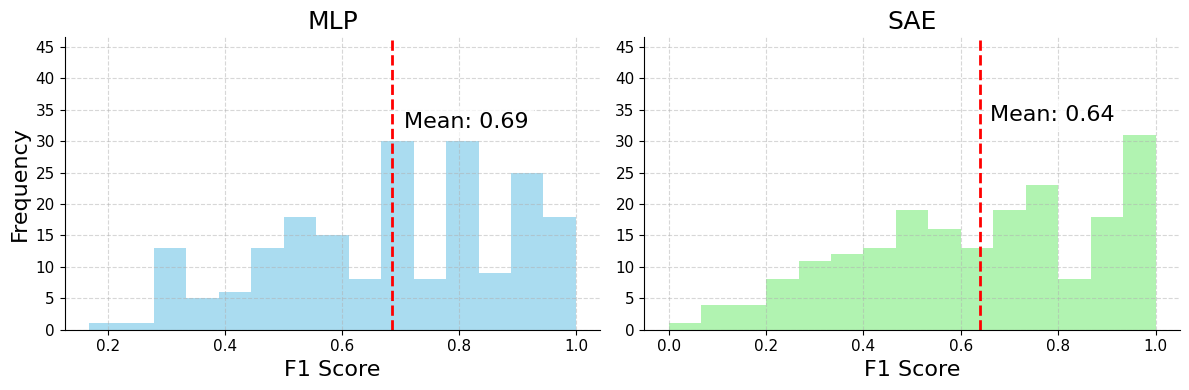

In [74]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Reset defaults
plt.rcdefaults()

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
BASE_FONT_SIZE = 16
DASHED_LINE_WIDTH = 2

# Load combined f1 scores mlp
combined_f1_scores_mlp = np.load('f1_scores_mlp.npy')
# Load combined f1 scores sae
combined_f1_scores_sae = np.load('f1_scores_sae.npy')

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Function to plot histogram and add mean label
def plot_histogram(ax, data, mean, color, title):
    n, bins, patches = ax.hist(data, bins=15, alpha=0.7, color=color)  # Removed edgecolor argument
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=DASHED_LINE_WIDTH)
    
    # Adjust the position of the mean label
    label_x = mean + 0.02  # Move label slightly to the right
    label_y = ax.get_ylim()[1] * 1.1  # Move label slightly down from the top
    
    ax.text(label_x, label_y, f'Mean: {mean:.2f}',
            horizontalalignment='left', verticalalignment='top', fontsize=BASE_FONT_SIZE,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    ax.set_title(title, fontsize=BASE_FONT_SIZE+2)
    ax.set_xlabel('F1 Score', fontsize=BASE_FONT_SIZE)
    ax.tick_params(labelsize=BASE_FONT_SIZE-5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

mean_f1_score_sae = np.mean(combined_f1_scores_sae)
std_f1_score_sae = np.std(combined_f1_scores_sae)
mean_f1_score_mlp = np.mean(combined_f1_scores_mlp)
std_f1_score_mlp = np.std(combined_f1_scores_mlp)

# Plot MLP histogram
plot_histogram(ax1, combined_f1_scores_mlp, mean_f1_score_mlp, 'skyblue', 'MLP')
ax1.set_ylabel('Frequency', fontsize=BASE_FONT_SIZE)

# Plot SAE histogram
plot_histogram(ax2, combined_f1_scores_sae, mean_f1_score_sae, 'lightgreen', 'SAE')

# Set the same y-axis range for both subfigures
max_count = max(
    max(np.histogram(combined_f1_scores_mlp, bins=15)[0]),
    max(np.histogram(combined_f1_scores_sae, bins=15)[0])
)
ax1.set_ylim(0, max_count * 1.5)
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylim(0, max_count * 1.5)
ax2.grid(True, linestyle='--', alpha=0.5)

# Use MaxNLocator to get integer tick locations on y-axis
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig("f1_score_distribution.pdf", bbox_inches='tight')

# Show the plot
plt.show()